In [4]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [5]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.4/572.4 KB 9.7 MB/s eta 0:00:00


In [6]:
import pandas as pd
import seaborn as sns
import numpy as np
import shap
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold, RandomizedSearchCV
from sklearn.metrics import accuracy_score, make_scorer, classification_report, confusion_matrix

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
from xgboost import XGBClassifier

# Umwandlung JSON-Request zu CSV
Dieser Code muss nur ausgeführt werden, wenn die Erhebung von Referenzdaten statt mit dem Beacon Backend Projekt, mit hook.ubeac.io erfasst wurden. In diesem Codesegment werden die JSON-Files verarbeitet und die Informationen so aufbereitet, dass diese zu denselben CSV-Files führen wie bei dem Beacon Backend Projekt.

In [13]:
import glob, os

path = "/content/drive/MyDrive/Colab Notebooks/Datenpunkte/"
whitelist = [100029571,100029586,100656666,1000411111,1000422222,1000454480,1230329194]

os.chdir(path+"JSON/")

for jsonFile in glob.glob("*.json"):
  filename = os.path.splitext(jsonFile)[0]

  df = pd.read_json(path+"/JSON/"+filename+".json",)

  dictionary_list = []

  #Iterates through all gateway traces
  for traceIndex in range(len(df)):
    currentTrace = df.iloc[traceIndex]

    #Extracts gateway timestamp
    timestamp = int(round(currentTrace.date.timestamp()))
    
    #Splits data string as it is not castable as json string
    #Two step is required to filter out , signs
    traceEntries = currentTrace.content.split('"')[3::2]
    for beaconIndex in range(len(traceEntries)):
      beaconData = traceEntries[beaconIndex].split(',')

      if len(beaconData[4]) >= 56: 
        #Extracts beacon data out of hex value
        beaconType = beaconData[4][6:18]
        uuid = beaconData[4][18:50]
        major = int(beaconData[4][50:54],16)
        minor = int(beaconData[4][54:58],16)
        majorminor = int(str(major)+str(minor))

        #Checks if current iteration should be skipped as signal is not of beacons
        if majorminor not in whitelist:
          continue
        #General signal power strength set for beacons
        measuredPower = -60

        #Specific power was set for beacon with below majorminor value
        if majorminor == 100656666:
          measuredPower = -75

        #Id of the tag of the Beacon
        tagId = beaconData[1]
        gateway = beaconData[2]
        rssi = int(beaconData[3])
        
        #Calculates distance with given formula
        distance = (10 ** ((measuredPower - rssi) / (10 * 3)))

        #Creates beacon entry as dictionary entry for efficent dataframe transformation
        beacon = {'_id':tagId, 'distance':distance, 'gateway':gateway, 
                'major':major, 'majorminor':majorminor, 'minor':minor, 
                'rssi':rssi, 'timestamp':timestamp,'type':beaconType,
                'uuid':uuid}

        dictionary_list.append(beacon)
  transformedDf = pd.DataFrame.from_dict(dictionary_list)
  
  transformedDf.to_csv(r''+path+"/CSV/"+filename+'.csv', index=False)

# Datenanalyse und -aufbereitung
In diesem Codesegment werden die Daten analysiert und aufbereitet

In [14]:
import glob, os

path = "/content/drive/MyDrive/Colab Notebooks/Datenpunkte/CSV/"

#Ensures that datapoints are evenly /normalized distributed
maxDfSize = 100

os.chdir(path)

frame = list()
print(type(frame))

for csvFile in glob.glob("*.csv"):
  filename = os.path.splitext(csvFile)[0]
  #Filenaming is made so that tag can be extracted
  tag = filename.split("_")[1]
  #Extended Filenaming is made so specific tag can be extracted
  specificTag = "".join(filename.split("_")[1:])
  df = pd.read_csv(path+filename+".csv")
  df['tag'] = tag
  df['specificTag'] = specificTag

  #Used to ensure that foreach measure point the exact max dataframe size is secured to limit it on
  #number of processed gateway posts requests
  minTimestamp = df.loc[:,["timestamp", "gateway"]].drop_duplicates().head(maxDfSize).timestamp.min()
  maxTimestamp = df.loc[:,["timestamp", "gateway"]].drop_duplicates().head(maxDfSize).timestamp.max()

  frame.append(df.loc[(df.timestamp >= minTimestamp) & (df.timestamp <= maxTimestamp)])
  
masterDf = pd.concat(frame)
masterDf.head(100)

<class 'list'>


,_id,distance,gateway,major,majorminor,minor,rssi,timestamp,type,uuid,tag,specificTag
0,F0F8F2044F23,5.011872,F3499FDED02E,10004,1000422222,22222,-81,1678461689,1AFF4C000215,FDA50693A4E24FB1AFCFC6EB07647825,Buero,BueroFensterBett
1,DC0D300F7252,1.995262,F3499FDED02E,10065,100656666,6666,-84,1678461689,1AFF4C000215,FDA50693A4E24FB1AFCFC6EB07647825,Buero,BueroFensterBett
2,04EE03C47286,4.298662,F3499FDED02E,10004,1000454480,54480,-79,1678461689,1AFF4C000215,FDA50693A4E24FB1AFCFC6EB07647825,Buero,BueroFensterBett
3,C630A073DD08,3.162278,F3499FDED02E,10002,100029586,9586,-75,1678461689,1AFF4C000215,0112233445566778899AABBCCDDEEFF0,Buero,BueroFensterBett
4,087CBF000028,7.943282,F3499FDED02E,10004,1000411111,11111,-87,1678461689,1AFF4C000215,FDA50693A4E24FB1AFCFC6EB07647825,Buero,BueroFensterBett
...,...,...,...,...,...,...,...,...,...,...,...,...
95,04EE03C47286,5.011872,F3499FDED02E,10004,1000454480,54480,-81,1678461712,1AFF4C000215,FDA50693A4E24FB1AFCFC6EB07647825,Buero,BueroFensterBett
96,087CBF000028,5.411695,F3499FDED02E,10004,1000411111,11111,-82,1678461712,1AFF4C000215,FDA50693A4E24FB1AFCFC6EB07647825,Buero,BueroFensterBett
97,DC0D300F7252,1.711328,F3499FDED02E,10065,100656666,6666,-82,1678461712,1AFF4C000215,FDA50693A4E24FB1AFCFC6EB07647825,Buero,BueroFensterBett
98,C630A073DD08,2.712273,F3499FDED02E,10002,100029586,9586,-73,1678461712,1AFF4C000215,0112233445566778899AABBCCDDEEFF0,Buero,BueroFensterBett


In [9]:
#This code allows to test if measurepoints are evenly / normalized distributed 
#(should be 50 if in json-file converter limit is set like documented)
test = masterDf.loc[:,["timestamp", "gateway","specificTag"]].drop_duplicates()
sample = test.groupby(['specificTag','gateway']).count()
sample.loc[sample.timestamp != sample.timestamp.median()]

,,timestamp
specificTag,gateway,


In [10]:
#Columns in CSV Files
#_id,distance,gateway,major,majorminor,minor,rssi,timestamp,beaconType,uuid
features = ["distance","major","majorminor","minor","rssi","gateway"]
joinParameter = ["_id","type","uuid","tag","specificTag","timestamp"]

#Set used interval for collected data (standard: 15, fast: 3)
requestIntervalInSeconds = 3

#Dinamical adapting on number of gateways used for experiment
gateways = masterDf.gateway.unique()

#Creating new Dataframes
adaptedMasterDf = pd.DataFrame()
tempDf = pd.DataFrame()

#Preparing Df for easy use
timeGatewayDf = masterDf.loc[:,["timestamp", "gateway"]].drop_duplicates()

#Repeat until every Timestamp and Gateway have combined / adapted to oneanother
while len(timeGatewayDf) > 0:
  currentLowestTimestamp = timeGatewayDf.timestamp.min()
  
  for gateway in gateways:
    timestamp = timeGatewayDf.loc[timeGatewayDf.gateway == gateway].timestamp.min()
    #Gets all beacon entries of current gateway with specified timestamp
    beaconMeasurementsOfGatewayDf = masterDf.loc[(masterDf.gateway == gateway) & (masterDf.timestamp == timestamp)].copy()
    #Sets the lowest timestamp to simplify join of dataframes
    beaconMeasurementsOfGatewayDf.timestamp = currentLowestTimestamp
    #Columns which could be used as feature are expanded with Name of Gateway as suffix
    beaconMeasurementsOfGatewayDf.columns = [col + '_' + gateway if col in features else col for col in beaconMeasurementsOfGatewayDf.columns]
    
    #If timestamp is not in range (ex. post not transmitted) current for iteration is aborted
    #as it has to be used for next iteration and combined with fitting post of other gateway
    if(timestamp > (currentLowestTimestamp + requestIntervalInSeconds)):
      beaconMeasurementsOfGatewayDf.drop(beaconMeasurementsOfGatewayDf.index, inplace=True)
    else:
      timeGatewayDf.drop(timeGatewayDf[(timeGatewayDf.gateway == gateway) & (timeGatewayDf.timestamp == timestamp)].index, inplace=True)
    
    #Checks if temp Dataframe already has entries and has to be merged or a copy is "dumped" in
    if len(tempDf) > 0:
      tempDf = pd.merge(tempDf,beaconMeasurementsOfGatewayDf, how='outer', on=joinParameter).copy()
    else:
      tempDf = beaconMeasurementsOfGatewayDf.copy()
  adaptedMasterDf = pd.concat([adaptedMasterDf, tempDf])
  tempDf.drop(tempDf.index , inplace=True)
adaptedMasterDf.reset_index(drop=True, inplace=True)

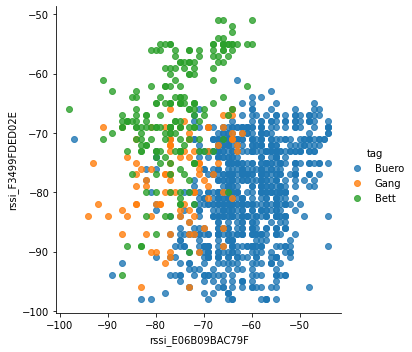

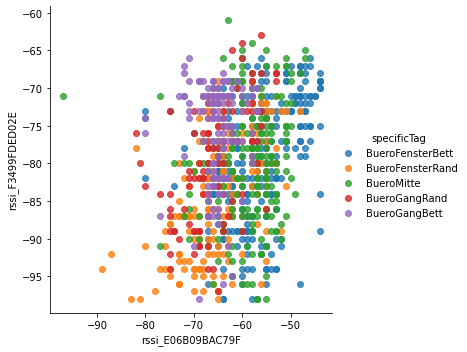

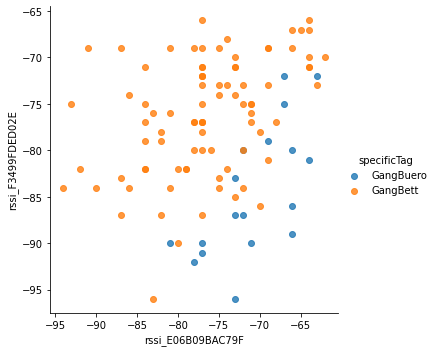

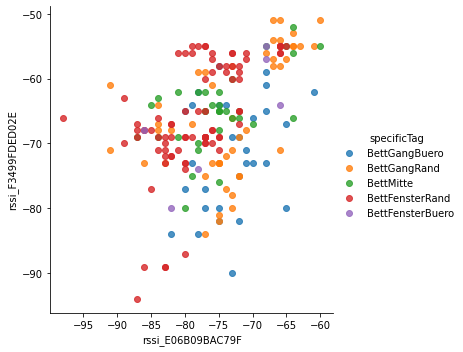

In [11]:
sns.lmplot(x='rssi_E06B09BAC79F', y='rssi_F3499FDED02E', data=adaptedMasterDf, hue='tag', fit_reg=False)
plt.show()

for tag in adaptedMasterDf.tag.unique():
  df = adaptedMasterDf.loc[adaptedMasterDf.tag == tag]
  sns.lmplot(x='rssi_E06B09BAC79F', y='rssi_F3499FDED02E', data=df, hue='specificTag', fit_reg=False)
  plt.show()